In [1]:
# https://gee-community-catalog.org/projects/annual_nlcd/#earth-engine-snippet
import ee
import xarray as xr
import pandas as pd
import numpy as np
import dask.array as da
import xee
from bbox import * 
from datetime import datetime
import pygeohydro as ph

# Trigger the authentication flow
ee.Authenticate()

# Initialize the Earth Engine library
ee.Initialize(project='satellite-modeling')

# Define the rectangle that encompasses Louisiana and Texas
bbox = ee.Geometry.Rectangle([lon_min, lat_min, lon_max, lat_max])

start_date = '2024-11-20T00:00'
end_date = datetime.now().strftime('%Y-%m-%dT%H:%M')

In [2]:
no2_hours = pd.read_csv("../../data/tempo_data/no2_file_hours.csv")
no2_hours=list(no2_hours['time_hr_ct'])
time_list = np.array(no2_hours, dtype="datetime64[ns]")

In [3]:
##################################################
# Load NDVI Data
##################################################

# List of climate variables to download from NLDAS
variables = ['NDVI', 'EVI']
# Load NLDAS hourly data and filter by region and date
dataset = ee.ImageCollection("MODIS/061/MOD13A2") \
            .filterDate(start_date, end_date) \
            .filterBounds(bbox)  \
            .select(variables)

ds = xr.open_dataset(dataset, engine='ee', crs='EPSG:4326', scale=0.01)
# Filter the dataset based on the latitude and longitude bounds
ds = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))


In [4]:
time_list = ds["time"].values.tolist()
time_list=np.array(time_list, dtype="datetime64[ns]")


In [5]:
time_list

array(['2024-12-02T00:00:00.000000000', '2024-12-18T00:00:00.000000000',
       '2025-01-01T00:00:00.000000000', '2025-01-17T00:00:00.000000000',
       '2025-02-02T00:00:00.000000000', '2025-02-18T00:00:00.000000000',
       '2025-03-06T00:00:00.000000000', '2025-03-22T00:00:00.000000000',
       '2025-04-07T00:00:00.000000000', '2025-04-23T00:00:00.000000000',
       '2025-05-09T00:00:00.000000000', '2025-05-25T00:00:00.000000000',
       '2025-06-10T00:00:00.000000000'], dtype='datetime64[ns]')

In [6]:
from collections import defaultdict

def separate_by_month_with_overlap(dates):
    # Convert dates to numpy datetime64 if not already
    dates = np.array(dates, dtype='datetime64[ns]')
    
    # Sort the dates
    dates = np.sort(dates)
    
    # Extract unique months
    months = np.unique(dates.astype('datetime64[M]'))
    
    # Dictionary to store grouped dates
    grouped = defaultdict(list)
    
    for i, month in enumerate(months):
        # Get dates for the current month
        current_month_dates = dates[(dates >= month) & (dates < month + np.timedelta64(1, 'M'))]
        
        # Add these dates to the group
        grouped[month].extend(current_month_dates.tolist())
        
        # Add the last date of the previous month if it exists
        if i > 0:  # Skip first month since no previous month
            last_date_prev_month = grouped[months[i - 1]][-1]
            grouped[month].insert(0, last_date_prev_month)
            
        grouped[month]=np.array(grouped[month], dtype="datetime64[ns]")
    # Convert defaultdict to a regular dict with sorted unique values for consistency
    return {month: sorted(set(dates), key=lambda d: d) for month, dates in grouped.items()}


In [7]:
month_dict = separate_by_month_with_overlap(time_list)

In [8]:
for i in range(len(list(month_dict.keys()))):
    month = list(month_dict.keys())[i]
    month_str = str(month)
    if month_str =='2024-11':
        pass
    else:
        dates = month_dict[month]
        ds_month = ds.sel(time=dates)
        ds_month.to_netcdf(f'../../data/NDVI_data/NDVI_{month_str}.nc')

In [9]:
ds_month

<xarray.Dataset> Size: 8MB
Dimensions:  (time: 2, lon: 1060, lat: 480)
Coordinates:
  * time     (time) datetime64[ns] 16B 2025-05-25 2025-06-10
  * lon      (lon) float64 8kB -98.9 -98.89 -98.88 ... -88.32 -88.31 -88.3
  * lat      (lat) float64 4kB 28.61 28.62 28.63 28.64 ... 33.37 33.38 33.39
Data variables:
    NDVI     (time, lon, lat) float32 4MB ...
    EVI      (time, lon, lat) float32 4MB ...
Attributes:
    crs:      EPSG:4326

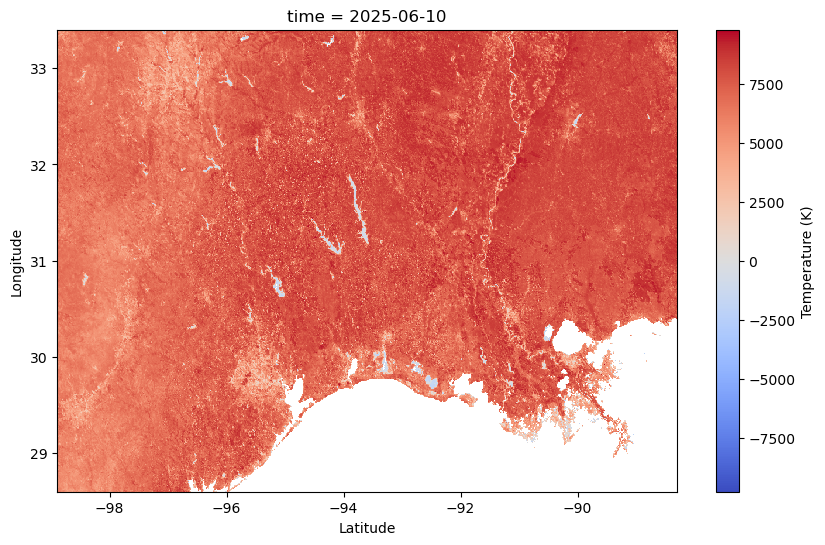

In [10]:
import matplotlib.pyplot as plt
# # Define your latitude and longitude bounds
# lat_min, lat_max = 28.6, 33.4  # Example latitude range
# lon_min, lon_max = -98.9, -88.3  # Example longitude range

# Select one hour of temperature data (e.g., the first timestamp)
hour_index = 1  # Change this to select a different hour if desired
temperature_data = ds_month['NDVI'].isel(time=hour_index)
# temperature_data = ds['Percent_Tree_Cover']

# Plot the data with switched axes
plt.figure(figsize=(10, 6))

# Plot with latitude on x-axis and longitude on y-axis
temperature_data.T.plot(
    cmap="coolwarm",  # Colormap for temperature visualization
    cbar_kwargs={'label': 'Temperature (K)'}  # Add color bar label
)

# Update axis labels
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()